# Influenza biomarkers
This is a collaboration with the Ingber lab for the identification of biomarkers associated with influenza infection. For this study we will use RNA-seq data generated by the Ingber lab as well as complementing the analyses with data that is publicly available.

## Libraries, functions, et al
Loading libraries and functions that I will be using throughout the analyses.

In [1]:
# libraries
library(tidyverse)
library(readr)
library(readxl)
# library(DRUID)
# library(grove)
library(DESeq2)
library(org.Hs.eg.db)
library(rpegeos)
library(diffnet)
library(hgu133plus2.db, quietly = TRUE)
library(limma, quietly = TRUE)



# function for tissue specificity
stouffer_specificity <- function(expression_data) {
  # stouffer method:
  # (((x - x_hat) / sd(x)) + ((y - y_hat) / sd(y))) / sqrt(2)
  # where x is row and y is column
  
  means_rows <- rowMeans(expression_data)
  means_cols <- colMeans(expression_data)
  
  sd_rows <- apply(expression_data, 1, sd)
  sd_cols <- apply(expression_data, 2, sd)
  
  z_rows <- apply(expression_data, 2, function(t) (t - means_rows) / sd_rows)
  z_cols <- apply(expression_data, 1, function(t) (t - means_cols) / sd_cols)
  z_cols <- t(z_cols)
  
  z_tot <- (z_rows + z_cols) / sqrt(2)
  return(z_tot) 
}
                  
# differential expression function ----
limma_dge <- function(expression_data,caseIds=list(),ctrIds)
{
  require(limma)
  if(!is.list(caseIds)) #ie, only one case
  {
    tmp_data <- expression_data[,c(ctrIds,caseIds)]
    
    expdes <- matrix(0,nrow=ncol(tmp_data),2) # experimental design
    expdes[seq(1,length(ctrIds)),1] <- 1
    expdes[seq(length(ctrIds)+1,length(ctrIds)+length(caseIds)),2] <- 1
    colnames(expdes) <- c("control","case")
    
    contmat <- makeContrasts(case-control,levels=expdes) # contrast matrix
    
    limma.fit <- lmFit(tmp_data,design=expdes)
    limma.fit <- contrasts.fit(limma.fit,contmat)
    limma.fit <- eBayes(limma.fit)
    
    res <- topTable(limma.fit,1,number=nrow(tmp_data),sort.by = "none",adjust.method = "fdr")
    return(res)

  } else {

    expdes <- matrix(0,nrow=ncol(expression_data),1)
    expdes[ctrIds,1] <- 1 # controls

    for(i in seq(1,length(caseIds)))
    {
      x <- matrix(0,nrow=ncol(expression_data),1)
      x[caseIds[[i]],1] <- 1
      expdes <- cbind(expdes,x)
    }

    tmp_data <- expression_data[,c(ctrIds,unlist(caseIds))]
    expdes <- expdes[c(ctrIds,unlist(caseIds)),]
    
    colnames(expdes) <- c("control",paste("case",seq(1,length(caseIds)),sep=""))
    myContrasts <- c(paste(colnames(expdes)[2:ncol(expdes)],"-",colnames(expdes)[1],sep=""))
    contmat <- contmat <- eval(as.call(c(as.symbol("makeContrasts"),as.list
                                         (myContrasts),levels=list(expdes)))) # contrast matrix

    limma.fit <- lmFit(tmp_data,design=expdes)
    limma.fit <- contrasts.fit(limma.fit,contmat)
    limma.fit <- eBayes(limma.fit)

    return(limma.fit)
  }
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
Warning message:
“package ‘tibble’ was built under R version 3.5.2”Warning message:
“package ‘tidyr’ was built under R version 3.5.2”Warning message:
“package ‘purrr’ was built under R version 3.5.2”Warning message:
“package ‘dplyr’ was built under R version 3.5.2”Warning message:
“package ‘stringr’ was built under R version 3.5.2”Warning message:
“package ‘forcats’ was built under R version 3.5.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘readxl’ was built under R version 3.5.2”Warning message:
“package ‘DESeq2’ was built under R version 3.5.2”Loading required package: S4Vectors
Warning message:
“package ‘S4Vectors’ was buil

## Data
On the data sets that we will look at in the context of this work:

 - RNA-seq data from this study
 - Data on viral infections (Zaas et al paper)
 - BioGPS data for tissue specificity calculations
 - TTRUST for characterization of human transcriptional regulators
 - Data from SignalP and HPA for the characterization of secreted proteins

### RNA-seq data (this study)

In [2]:
# data from project ----
# count data 
count_data <- read_csv("data/rna_seq/STAR_Gene_Counts.csv")
gene_ids <- count_data$Gene_ID
count_data <- count_data %>% dplyr::select(., -Gene_ID)

# metadata
metadata <- readxl::read_xlsx("data/rna_seq/052918_RNAseq_Sample IDs.xlsx")
t1 <- gsub("5/2", "May2", gsub("5/1", "May1", gsub("-", "_", metadata$`Tube ID`)))

metadata <- metadata %>% 
  dplyr::mutate(., sample_name = t1)

metadata <- metadata[match(colnames(count_data), metadata$sample_name), ]

group <- character(length = nrow(metadata))
group[metadata$Sample == "Control"] <- "control"
group[metadata$Sample == "Virus Treated"] <- "virus"
group[metadata$Sample == "Poly IC Treated"] <- "poly_ic"

metadata <- metadata %>% 
  dplyr::mutate(., group = group)

sample_data <- tibble(sample_name = metadata$sample_name,
                      time_point = as.numeric(gsub("h", "", metadata$`Time point`)),
                      group = metadata$group)

sample_data <- sample_data %>% 
  dplyr::mutate(., group_time = paste(group, time_point, sep = "_"))


# process data ahead of analysis ----
# remove probes with zero counts throughout
nix <- which(rowSums(count_data) == 0)
if(length(nix) != 0) {
  gene_ids <- gene_ids[-nix]
  count_data <- count_data[-nix, ]
}

# remove gene ids with multiple entrez mappings
gkey <- AnnotationDbi::select(x = org.Hs.eg.db, 
                              keys = gene_ids, 
                              columns = "ENTREZID", 
                              keytype = "SYMBOL")

nix <- which(sapply(gene_ids, function(y) length(which(gkey$SYMBOL == y))) != 1)
if(length(nix) != 0) {
  gene_ids <- gene_ids[-nix]
  count_data <- count_data[-nix, ]
}

# remove genes with NA entrez id
gkey <- AnnotationDbi::select(x = org.Hs.eg.db, 
                              keys = gene_ids, 
                              columns = "ENTREZID", 
                              keytype = "SYMBOL")

nix <- which(is.na(gkey$ENTREZID))
if(length(nix) != 0) {
  gene_ids <- gene_ids[-nix]
  count_data <- count_data[-nix, ]
}

# frequency across samples
# minimum 5 read counts, at least in 75% of the samples
x1 <- apply(count_data, 1, function(y) length(which(y >= 5)))
x1 <- which(x1 >= round(0.75 * ncol(count_data)))

count_data <- count_data[x1, ]
gene_ids <- gene_ids[x1]

Parsed with column specification:
cols(
  .default = col_double(),
  Gene_ID = col_character()
)
See spec(...) for full column specifications.
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


### Differential expression
The differential expression for the RNA-seq data will be done using `DESeq2`. Later on, for analyses of the microarray data from Zaas et al, I will use the `limma` package.

In [3]:
# differential expression ----
# use deseq2
dds <- DESeqDataSetFromMatrix(countData = count_data,
                              colData = sample_data,
                              design = ~ group_time)

dds <- DESeq(object = dds)

# ec_e_ab_res <- results(dds,contrast=c("Group","H_E_AB","M_E_AB"),alpha=0.05,lfcThreshold = 1)
contrast_v18 <- c("group_time", "virus_18", "control_18")
contrast_ic18 <- c("group_time", "poly_ic_18", "control_18")

res_v18 <- results(dds,
        contrast = contrast_v18,
        pAdjustMethod = "fdr",
        cooksCutoff = FALSE)

res_v18 <- res_v18 %>% 
  tibble::add_column(., gene = gene_ids, .before = 1)

res_ic18 <- results(dds,
                   contrast = contrast_ic18,
                   pAdjustMethod = "fdr",
                   cooksCutoff = FALSE)

res_ic18 <- res_ic18 %>%
  tibble::add_column(., gene = gene_ids, .before = 1)




converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
Warning message:
“`.data` must be a data frame in `add_column()`.
This warning is displayed once per session.”

The analyses above (more plots needed?) allows us to identify a set of **host** genes that respond to the influenza infection specifically (when compared to a treatment with poly:IC).

In [4]:
# viral specific genes
fold_thr <- 1
pval <- 0.01

virus_sig <- with(res_v18, which(padj < 0.05 & log2FoldChange > 1))
ic_sig <- with(res_ic18, which(padj < 0.05 & abs(log2FoldChange) > 1))

virus_specific <- setdiff(virus_sig, ic_sig)
gene_ids[virus_specific]

[1] "ARID5A"     "CASP1"      "CEACAM1"    "HIRA"       "SCAMP1-AS1"
  [6] "C15orf48"   "SPOCD1"     "PHLPP2"     "IRF1"       "PNPT1"     
 [11] "TRIM22"     "HDX"        "TLR3"       "TRIM38"     "ELOVL7"    
 [16] "PPM1J"      "NMI"        "SPATS2L"    "ZCCHC2"     "SKIDA1"    
 [21] "HCG4"       "FANCA"      "APOL4"      "IL1RN"      "SOCS2"     
 [26] "GIMAP2"     "TRIM25"     "MILR1"      "GTPBP2"     "IFI16"     
 [31] "STXBP6"     "PMAIP1"     "LEMD1"      "PDCD1LG2"   "TIAM2"     
 [36] "CMTR1"      "KRT39"      "RORB"       "TRIM21"     "NUB1"      
 [41] "DIP2C"      "CFB"        "HES4"       "WARS"       "C19orf38"  
 [46] "KRT6B"      "MEF2C"      "PSMB9"      "NT5C3A"     "TAP2"      
 [51] "SECTM1"     "THSD1"      "ADAR"       "SEMA3D"     "IFITM2"    
 [56] "APOBEC3G"   "CYP26B1"    "CPED1"      "GNB4"       "TOR1B"     
 [61] "HTR2B"      "SCO2"       "ARL9"       "PSMB8"      "CYP2J2"    
 [66] "APOL6"      "MMP13"      "ZFYVE26"    "GSDMB"      "SHISA5"    
 [71] "MOB3C"      "C1R"        "LY6E"       "MT2A"       "STARD5"    
 [76] "APOL3"      "IL15RA"     "KCNE4"      "EHD4"       "RABGAP1L"  
 [81] "LMO2"       "MLKL"       "FLJ32255"   "SAMD9"      "TNFSF10"   
 [86] "SLFN5"      "PTPRR"      "MASTL"      "ACSL1"      "OGFR"      
 [91] "CHODL"      "USP30-AS1"  "ACE2"       "MYD88"      "TMEM92"    
 [96] "IFI30"      "NRG2"       "SERPINE1"   "GBP2"       "BTC"       
[101] "ABAT"       "OPTN"       "PLCL1"      "CNP"        "SLC16A1"   
[106] "LIFR"       "PIK3AP1"    "CD68"       "GJD3"       "TDRD7"     
[111] "TREX1"      "SLC25A28"   "ACKR4"      "TTN"        "ZNFX1"     
[116] "RBCK1"      "PSME2"      "FBXO6"      "HESX1"      "TRIM5"     
[121] "BCL2L14"

### Gene set enrichment (rpegeos package)
With the set of genes that are specific for host response to viral infection, we can perform a pathway enrichment to hypothesize on biological processes being affected by the infection. This will be done with the `rpegeos` package and I will illustrate (for now) with patwhays from Reactome. 

'select()' returned 1:1 mapping between keys and columns
Checks and balances...
--- Pathway enrichments with rPEGEOS ---

Available gene sets:
[1] KEGG
[2] PharmGKB
[3] Small Molecule Pathway DB
[4] WikiPathways
[5] SignaLink
[6] HumanCyc
[7] Biocarta
[8] Reactome
[9] INOH
[10] PID
[11] NetPath
[12] EHMN
[13] Gene Ontology: Biological Processes
[14] Gene Ontology: Cellular Component
[15] Gene Ontology: Molecular Function
[16] Broad Hallmark



Selection: 8
Fold change threshold: 1
p-value threshold: 0.01
Number of random sets: 10000


Counting gene representation...
Cleaning up gene sets...
Generating query vector...
Computing cosine similarities...
Running random sets...
Compiling results...

----------
Summary: 
Number of pathways with probability random < 0.001:  21
Number of pathways with probability random < 0.01:  94
Top 10 enriched pathways: 


                                                  geneset enrichment_score
1           cytosolic_sensors_of_pathogen_associated_dna_         5.062242
2                    vif_mediated_degradation_of_apobec3g         5.060445
3                     cytokine_signaling_in_immune_system         5.052481
4                         interferon_alpha_beta_signaling         5.048374
5                                    interferon_signaling         5.048060
6                    signaling_by_the_b_cell_receptor_bcr         5.046604
7       sting_mediated_induction_of_host_immune_responses         4.765334
8                     ligand_dependent_caspase_activation         4.748963
9  regulation_of_innate_immune_responses_to_cytosolic_dna         4.580617
10                      ripk1_mediated_regulated_necrosis         4.571989


----------

** DONE **


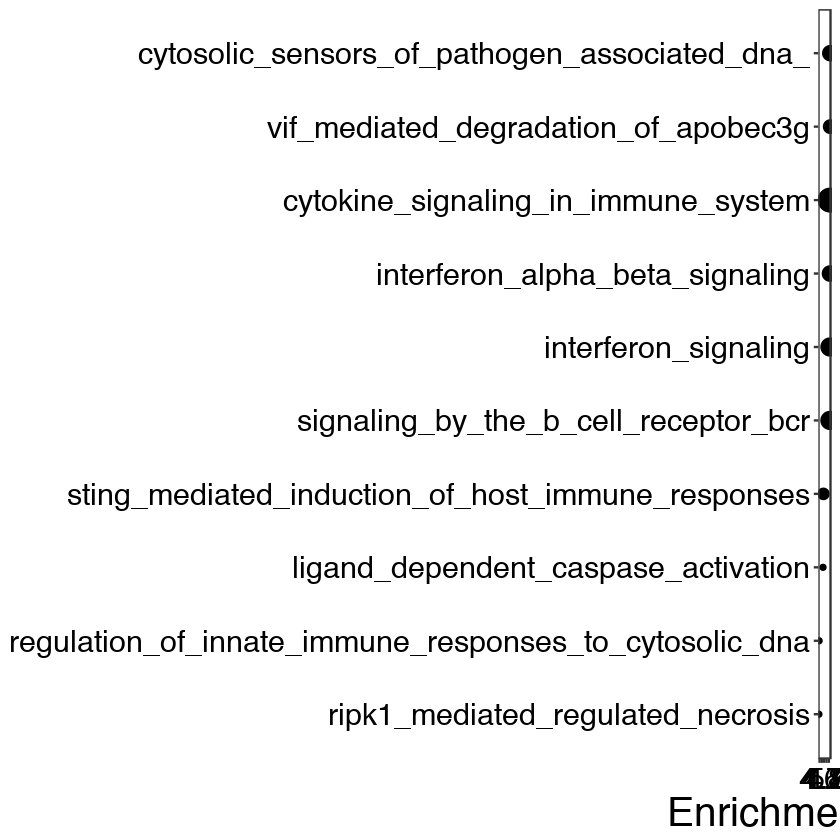

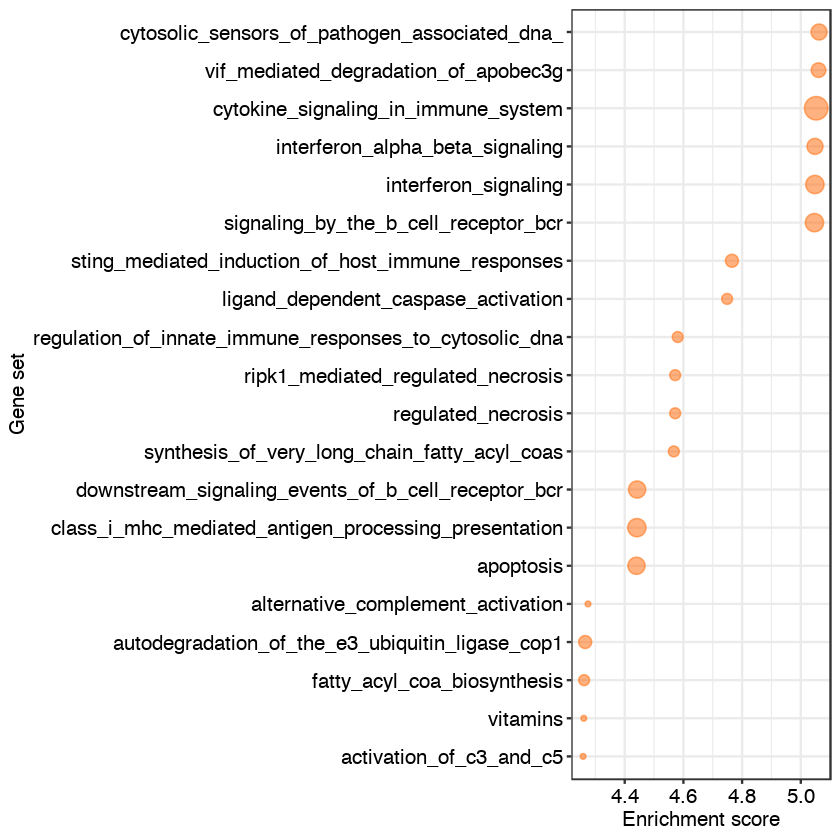

In [5]:
# gene set enrichment with rpegeos ----
gnames <- gene_ids[virus_specific]
gkey <- AnnotationDbi::select(x = org.Hs.eg.db, 
                              keys = gnames, 
                              columns = "ENTREZID", 
                              keytype = "SYMBOL")
chip_gset <- cbind(gkey$ENTREZID, res_v18$log2FoldChange[virus_specific], res_v18$padj[virus_specific])
chip_gset <- apply(chip_gset, 2, as.numeric)
chip_enr <- rpegeos::enrich_geneset(gene_set = chip_gset)

chip_enr %>%
  dplyr::slice(1:20) %>%
  ggplot() +
  geom_point(aes(y = enrichment_score, x = forcats::fct_reorder(geneset, enrichment_score), size = number_genes), alpha = 0.5, color = "#ff6600") +
  labs(x = "Gene set", y = "Enrichment score") +
  coord_flip() + 
  theme_bw() + 
  theme(axis.title = element_text(size = 12, color = "black"),
        axis.text = element_text(size = 12, color = "black"),
        legend.position = "none")
#ggsave(filename = paste0("res/", Sys.Date(),"_chip-data-enrichment.png"),
#       device = "png",
#       height = 8,
#       width = 11,
#       dpi = 600)

In [ ]:
length(intersect(chip_gset[, 1], colnames(rpegeos::pathway_sets[[8]]$tfidf)))

## Tissue specificity
In order to potentially identify biomarkers specific to the lung (since it's a respiratory airway infection), we will use the data from [BioGPS](www.biogps.org) to characterize tissue specificity. This is done using Stouffer's method for a z-score test. This method allows one to combine z-score values from N normal distributions by 

$$Z = \frac{\sum_{i=1}^N Z_{i}}{\sqrt N}$$

where N is the number of distributions and Z is the calculated z-score. From this we can adapt it as:

$$ts_{gene, tissue} = \frac{Z_{tissue} + Z_{gene}}{\sqrt 2}$$

to define a tissue specificity taking into account the expression levels of a given gene in a given tissue.

In [ ]:
# biogps data ----
load(file = "data/2019-02-13_biogps.RData")

# average of tissues ----
utis <- unique(biogps_data$tissues)
avg_E <- matrix(0, nrow = nrow(biogps_data$expression), ncol = length(utis))
for (i in seq(1, length(utis))) {
  u1 <- which(biogps_data$tissues == utis[i])
  if (length(u1) > 1) {
    avg_E[, i] <- rowMeans(biogps_data$expression[, u1])
  } else {
    avg_E[, i] <- biogps_data$expression[, u1]
  }
}

ts_stouffer <- stouffer_specificity(avg_E) # <-- see how i calculate the average of tissue expression

Let's look at the distribution of scores:

In [ ]:
hist(ts_stouffer, breaks = 50)

We don't care for negative specificities (negative z-scores). Let's now count how many genes are specific at different thresholds.

In [ ]:
tissue_spec <- tibble::tibble(count = c(length(which(apply(ts_stouffer, 1, function(y) length(which(y > 1))) != 0)),
                                       length(which(apply(ts_stouffer, 1, function(y) length(which(y > 2))) != 0)),
                                       length(which(apply(ts_stouffer, 1, function(y) length(which(y > 3))) != 0)),
                                       length(which(apply(ts_stouffer, 1, function(y) length(which(y > 4))) != 0)),
                                       length(which(apply(ts_stouffer, 1, function(y) length(which(y > 5))) != 0)),
                                       length(which(apply(ts_stouffer, 1, function(y) length(which(y > 6))) != 0))),
                             group = c("z > 1", "z > 2", "z > 3", "z > 4", "z > 5", "z > 6"))


tissue_spec %>% ggplot() + geom_col(aes(y = count, x = group))

Based on these results I will use a Z threshold > 3 to classify a gene as specific to a given tissue. I will also limit genes to be deemed significant if they show specificity to at most 2 tissues.

In [ ]:
stouf_thr <- 3
num_tissues <- 2

spec_mat <- matrix(0, nrow = nrow(x = ts_stouffer), ncol = ncol(ts_stouffer))
spec_mat[ts_stouffer >= stouf_thr] <- 1

spec_genes <- which(rowSums(spec_mat) <= num_tissues)
lung_genes <- biogps_data$genes$SYMBOL[intersect(which(spec_mat[, 2] == 1), spec_genes)]
sort(lung_genes)
length(lung_genes)

This allowed me to identify 93 genes that are specific to the lung. We will carry these over in subsequent analyses.

## Analysis of public data (Zaas et al)

In [ ]:
# DREAM respiratory challenge data ----
load("data/public_data/zaas_data_05152018.RData")

E <- data[[1]]
G <- data[[2]]
S <- data[[3]]

# separate viral groups ----
rhino_group <- which(S$virus.group == "Rhino")
rsv_group <- which(S$virus.group == "RSV")
flu_group <- which(S$virus.group == "H3N2")

symp <- which(S$clinical.group == 1)
asymp <- which(S$clinical.group == -1)

# tolerant are those that are asymptomatic but exhibit high viral shedding (high viral load)
# get samples at peak symptoms (if asymptomatic, jackson score < 6 over 5 days)
peak <- grep("peak",S$time.point)

flu_peak_symp <- intersect(flu_group,intersect(symp,peak))
flu_peak_asymp <- intersect(flu_group,intersect(asymp,peak))

rsv_peak_symp <- intersect(rsv_group,intersect(symp,peak))
rsv_peak_asymp <- intersect(rsv_group,intersect(asymp,peak))

hrv_peak_symp <- intersect(rhino_group,intersect(symp,peak))
hrv_peak_asymp <- intersect(rhino_group,intersect(asymp,peak))

# differential expression ----
xx1 <- limma_dge(expression_data = E,
                 ctrIds = flu_peak_asymp,
                 caseIds = flu_peak_symp)

xx2 <- limma_dge(expression_data = E,
                 ctrIds = rsv_peak_asymp,
                 caseIds = rsv_peak_symp)

xx3 <- limma_dge(expression_data = E,
                 ctrIds = hrv_peak_asymp,
                 caseIds = hrv_peak_symp)


diff_genes_flu <- which(xx1$adj.P.Val < 0.01 & abs(xx1$logFC) > 1)
diff_genes_rsv <- which(xx2$adj.P.Val < 0.01 & abs(xx2$logFC) > 1)
diff_genes_hrv <- which(xx3$adj.P.Val < 0.01 & abs(xx3$logFC) > 1)


# flu biomarkers ----
# these are genes that are differentially expressed in flu but not
# in the other 2 infection models
diff_genes_flu <- setdiff(diff_genes_flu,
                          union(diff_genes_hrv, diff_genes_rsv))

diff_res <- tibble::tibble(gene_id=G$ENTREZID[diff_genes_flu],
                       gene_symbol=G$SYMBOL[diff_genes_flu],
                       fold_change=xx1$logFC[diff_genes_flu],
                       fdr_pvalue=xx1$adj.P.Val[diff_genes_flu])

# gene set enrichment with rpegeos ----
library(rpegeos)
gset <- cbind(G$ENTREZID[diff_genes_flu], xx1$logFC[diff_genes_flu], xx1$adj.P.Val[diff_genes_flu])
gset <- apply(gset, 2, as.numeric)
flu_enr <- rpegeos::enrich_geneset(gene_set = gset)

flu_enr %>% 
  # dplyr::mutate(., probability_random = replace(probability_random, probability_random == 0, 1/10000)) %>% 
  # dplyr::mutate(., enrichment_score = -log10(probability_random) + 1 + (cosine_similarity * number_genes)) %>%
  dplyr::arrange(., desc(enrichment_score)) %>% 
  dplyr::slice(1:20) %>%
  ggplot() +
  geom_point(aes(x = forcats::fct_reorder(geneset, enrichment_score), y = enrichment_score, size = number_genes), alpha = 0.5) + 
  coord_flip() +
  theme_bw() +
  theme(axis.text = element_text(size = 12, color = "black"),
       legend.position = "none")

## Differential network analyses using the Zaas data
This takes some time to run, so it has been pre-computed. This was run using the `diffnet` package that I wrote. The goal here is to identify changes in network topology that allows us to characterize the host response to influenza infection. We will start by characterizing the topological differences based on data from the Zaas paper and then follow it with genes that are viral response specific.

In [ ]:
# get data
load("res/2019-04-09_diffnet_zaas.RData")
load(file = "data/2018-04-30_ttrust_data.RData")

# filtering
tmp2 <- DN %>% 
  dplyr::mutate(., x_name = AnnotationDbi::select(x = org.Hs.eg.db, keys = as.character(x), keytype = "ENTREZID", columns = "SYMBOL")$SYMBOL) %>%
  dplyr::mutate(., y_name = AnnotationDbi::select(x = org.Hs.eg.db, keys = as.character(y), keytype = "ENTREZID", columns = "SYMBOL")$SYMBOL) %>%
  dplyr::filter(., !is.na(x_name), !is.na(y_name)) %>% 
  dplyr::mutate(., x_tf = x_name %in% ttrust_data$tf) %>%
  dplyr::mutate(., x_tf = replace(x_tf, x_tf == TRUE, 1), x_tf = replace(x_tf, x_tf == FALSE, 0)) %>%
  dplyr::mutate(., y_tf = y_name %in% ttrust_data$tf) %>%
  dplyr::mutate(., y_tf = replace(y_tf, y_tf == TRUE, 1), y_tf = replace(y_tf, y_tf == FALSE, 0))


# look at where the virus specific genes and lung specific genes are
xx <- gene_ids[virus_specific]
xx <- AnnotationDbi::select(x = org.Hs.eg.db, keys = xx, columns = "ENTREZID", keytype = "SYMBOL")

tmp <- tmp2 %>% 
  dplyr::filter(., x %in% xx$ENTREZID | y %in% xx$ENTREZID) %>% 
  dplyr::filter(., y %in% xx$ENTREZID | x %in% xx$ENTREZID) %>% 
  dplyr::filter(., change_type != "edge present, same sign") %>% 
  dplyr::mutate(., x_lung = x_name %in% lung_genes) %>%
  dplyr::mutate(., x_lung = replace(x_lung, x_lung == TRUE, 1), x_lung = replace(x_lung, x_lung == FALSE, 0)) %>%
  dplyr::mutate(., y_lung = y_name %in% lung_genes) %>%
  dplyr::mutate(., y_lung = replace(y_lung, y_lung == TRUE, 1), y_lung = replace(y_lung, y_lung == FALSE, 0)) %>% 
  dplyr::filter(., x_lung == 1 | y_lung == 1) %>% 
  dplyr::filter(., x_name %in% gene_ids, y_name %in% gene_ids)


node_names <- c(tmp$x, tmp$y)
node_names <- unique(node_names)
node_names <- AnnotationDbi::select(x = org.Hs.eg.db, keys = as.character(node_names), columns = "SYMBOL", keytype = "ENTREZID")

node_names <- node_names %>% 
  dplyr::mutate(., lung_gene = node_names$SYMBOL %in% lung_genes) %>%
  dplyr::mutate(., lung_gene = replace(lung_gene, lung_gene == TRUE, 1), lung_gene = replace(lung_gene, lung_gene == FALSE, 0)) %>%
  dplyr::mutate(., virus_gene = node_names$SYMBOL %in% gene_ids[virus_specific]) %>%
  dplyr::mutate(., virus_gene = replace(virus_gene, virus_gene == TRUE, 1), virus_gene = replace(virus_gene, virus_gene == FALSE, 0)) %>%
  dplyr::mutate(., log2fc = res_v18$log2FoldChange[match(node_names$SYMBOL, gene_ids)]) %>%
  dplyr::mutate(., p_val = res_v18$padj[match(node_names$SYMBOL, gene_ids)])



# write files to load into cytoscape ----
# maybe do something for igraph instead? 
# write_delim(x = tmp, "res/2019-04-08_diffnet_results.txt", delim = "\t", col_names = TRUE)
# write_delim(x = node_names, "res/2019-04-08_diffnet_results_nodenames.txt", delim = "\t", col_names = TRUE)


# enrichment of nodes in subnetwork ----
subnet_gset <- cbind(node_names$ENTREZID, node_names$log2fc, node_names$p_val)
subnet_gset <- apply(subnet_gset, 2, as.numeric)
subnet_enr <- rpegeos::enrich_geneset(gene_set = subnet_gset)

In [ ]:
subnet_enr %>% dplyr::filter(., probability_random < 0.001)

In [ ]:
tmp %>% 
#dplyr::filter(., x_lung == 1 | y_lung == 1) %>% 
dplyr::filter(., x_tf == 1 | y_tf == 1) %>%
dplyr::select(., x_name, y_name, x_tf, y_tf, cor1, cor2, change_type)

## Enrichment comparison

In [ ]:
a1 <- flu_enr %>% dplyr::slice(1:15)
a2 <- subnet_enr %>% dplyr::slice(1:15)
a3 <- chip_enr %>% dplyr::slice(1:15)

a1 <- a1 %>% 
  tibble::add_column(., group = "zaas data") %>% 
  tibble::add_column(., rank = seq(1, nrow(a1))) %>%
  dplyr::mutate(., norm_score = (enrichment_score - min(enrichment_score)) / (max(enrichment_score) - min(enrichment_score)))

a2 <- a2 %>% 
  tibble::add_column(., group = "network data") %>% 
  tibble::add_column(., rank = seq(1, nrow(a2))) %>%
  dplyr::mutate(., norm_score = (enrichment_score - min(enrichment_score)) / (max(enrichment_score) - min(enrichment_score)))

a3 <- a3 %>% 
  tibble::add_column(., group = "transwell data") %>% 
  tibble::add_column(., rank = seq(1, nrow(a3))) %>%
  dplyr::mutate(., norm_score = (enrichment_score - min(enrichment_score)) / (max(enrichment_score) - min(enrichment_score)))

a4 <- rbind(a1, a2, a3)

a4 %>% 
  #dplyr::filter(., group != "network data") %>%
  ggplot() + 
  geom_point(aes(x = forcats::fct_reorder(geneset, enrichment_score), y = enrichment_score, color = group, size = number_genes)) +
  scale_color_manual(values = c("#ff9933", "#cc99cc", "#99cc99")) +
  labs(x = "Gene set", y = "Enrichment score") +
  coord_flip() + 
  facet_grid(. ~ group, scales = "free") +
  theme_bw() + 
  theme(axis.text = element_text(color = "black"),
        axis.title = element_text(color = "black"),
        strip.text = element_text(color = "black"),
        legend.position = "none")
#ggsave(filename = paste0("res/", Sys.Date(),"_compare-enrichments.png"),
#       device = "png",
#       height = 8,
#       width = 11,
#       dpi = 600)

## Virus-specific biomarkers

In [ ]:
# potential host-infection biomarkers to flu infection ----
vb <- intersect(lung_genes, gene_ids[virus_specific])
sort(vb)

In [ ]:
# plot ----
b2 <- res_v18$log2FoldChange[which(gene_ids %in% vb)] # <-- chip data
#b3 <- y1$logFC[which(gene_mappings_copd$SYMBOL %in% b1)] # <-- copd data
b4 <- xx1$logFC[which(G$SYMBOL %in% vb)] # <-- zaas data, flu
b5 <- xx2$logFC[which(G$SYMBOL %in% vb)] # <-- zaas data, rsv
b6 <- xx3$logFC[which(G$SYMBOL %in% vb)] # <-- zaas data, hrv

dge_groups <- tibble(group = c(rep("this study", length(b2)),
                               #rep("copd data (benam et al)", length(b3)),
                               rep("flu infection data (zaas et al)", length(b4)),
                               rep("rsv infection data (zaas et al)", length(b5)),
                               rep("hrv infection data (zaas et al)", length(b6))),
                     gene_name = c(gene_ids[gene_ids %in% vb], 
                                   #gene_mappings_copd$SYMBOL[which(gene_mappings_copd$SYMBOL %in% b1)],
                                   G$SYMBOL[G$SYMBOL %in% vb],
                                   G$SYMBOL[G$SYMBOL %in% vb],
                                   G$SYMBOL[G$SYMBOL %in% vb]),
                     fold_data = c(b2, b4, b5, b6))

dge_groups %>% 
  dplyr::filter(., group != "copd data (benam et al)", fold_data > 1) %>%
  ggplot() + 
  geom_point(aes(x = group, y = fold_data, color = group), size = 5, alpha = 0.5) + 
  # scale_color_manual(values = c("purple", "orange")) +
  facet_wrap(. ~ gene_name) + 
  labs(x = NULL, y = "log2(fold difference to control)") +
  theme_bw() + 
  theme(axis.text.x = element_text(size = 12, color = "black", angle = 90, hjust = 1, vjust = 0.5),
        axis.text.y = element_text(size = 12, color = "black"),
        axis.title = element_text(size = 18, color = "black"),
        legend.position = "none")
#ggsave(filename = paste0("res/", Sys.Date(),"_LUNG-SPECIFIC-COMPARISON_fold_changes.png"),
#       device = "png",
#       height = 8,
#       width = 11,
#       dpi = 600)

These results seem to indicate that the TNFSF10 and WARS genes, which are specific to lung and are up-regulated upon influenza infection in our system, are also up-regulated in _in vivo_ samples (blood draws from healthy volunteers infected with different airway viruses -- Zaas paper). Interestingly, WARS seems to be related only to influenza infection and not RSV or HRV.

In [ ]:
#intersect(gene_ids[virus_specific], lung_genes)

In [ ]:
#b1

## Secreted biomarkers
Another aspect of biomarker characterization that I wanted to capture was to identify the set of known (or predicted) secreted proteins/peptides in the host response we are observing with the influenza infection. For that, I used data from SignalP and the human protein atlas and the annotations therein to identify the host-response specific secreted biomolecules.

In [ ]:
# signal peptides ----
sig_pep <- read_xlsx("~/work/data/2019-03-07_signal_peptides_human.xlsx")

sig_peps_names <- AnnotationDbi::select(x = org.Hs.eg.db, keys = as.character(sig_pep$`Accession Number`), keytype = "UNIPROT", columns = c("ENTREZID", "SYMBOL"))
sig_peps_names <- sig_peps_names[which(!is.na(sig_peps_names$ENTREZID)), ]

# differentially abundant signal peptides in our data
virus_sig_peps <- intersect(sig_peps_names$SYMBOL, gene_ids[virus_specific])

# secreted proteins ----
# based on HPA predicted data
hpa_pred <- read_delim("~/work/data/2019-03-07_HPA_predicted_secreted_proteins.tsv", delim = "\t")
hpa_sec <- hpa_pred[grep("secreted", hpa_pred$`Protein class`), ]

virus_secp <- intersect(hpa_pred$Gene, gene_ids[virus_specific])

# predicted secreted biomarkers ----
virus_biom_sec <- union(virus_secp, virus_sig_peps)
length(virus_biom_sec)
virus_biom_sec

This has allowed us to identify 33 genes that are secreted or have secretion tags that are differentially expressed under our conditions, independent of tissue specificity. We can look at tissue specificity of these genes later.

## Secreted vius-specific

In [ ]:
# secreted virus specific ----
d2 <- res_v18$log2FoldChange[which(gene_ids %in% virus_biom_sec)] # <-- chip data
d4 <- xx1$logFC[which(G$SYMBOL %in% virus_biom_sec)] # <-- zaas data, flu
d5 <- xx2$logFC[which(G$SYMBOL %in% virus_biom_sec)] # <-- zaas data, rsv
d6 <- xx3$logFC[which(G$SYMBOL %in% virus_biom_sec)] # <-- zaas data, hrv

sec_genes <- tibble(group = c(rep("this study", length(d2)),
                               rep("flu infection data (zaas et al)", length(d4)),
                             rep("rsv infection data (zaas et al)", length(d5)),
                             rep("hrv infection data (zaas et al)", length(d6))),
                     gene_name = c(gene_ids[which(gene_ids %in% virus_biom_sec)], 
                                   G$SYMBOL[which(G$SYMBOL %in% virus_biom_sec)],
                                  G$SYMBOL[which(G$SYMBOL %in% virus_biom_sec)],
                                  G$SYMBOL[which(G$SYMBOL %in% virus_biom_sec)]),
                     fold_data = c(d2, d4, d5, d6))

sec_genes %>% 
  ggplot() + 
  geom_point(aes(x = forcats::fct_reorder(gene_name, fold_data, .desc = TRUE), y = fold_data, color = group), size = 3, alpha = 0.5) + 
  geom_hline(yintercept = 1, color = "black", lty = 2) + 
  # scale_color_manual(values = c("purple", "orange")) +
  labs(x = "Secreted biomarker", y = "log2(fold difference to control)") +
  theme_bw() + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 12),
        axis.text.y = element_text(size = 12),
       legend.position = "bottom")

#ggsave(filename = paste0("res/", Sys.Date(),"_SECRETED-BIOMARKERS_comparison.png"),
#       device = "png",
#       height = 8,
#       width = 11,
#       dpi = 600)

The interesting thing about these results is the characterization of biomarkers that are pan-viral versus viral-specific. As an example, TOR1B seems to be influenza specific while CEACAM1 appears to be pan-viral. Could be an interesting discussion point with the experimental team.